<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_Neural_Net_MLP_underSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Mounted at /content/drive


In [2]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
!pip install --quiet fastai==2.2.5

     |████████████████████████████████| 194kB 5.4MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 


# Preprocessing

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)
# data = pd.get_dummies(data)

In [5]:
cols = mf.get_col(data)

In [6]:
from fastai.tabular.all import *

In [7]:
categorical_col = data.select_dtypes(include=['object']).columns.tolist()

In [8]:
def get_numerical_col(data, categorical_col):
  numerical_col = []
  for col in data.columns:
    if col not in categorical_col and col != 'isFraud':
      numerical_col.append(col)
  return numerical_col

numerical_col = get_numerical_col(data, categorical_col)

Tutorial: https://docs.fast.ai/tutorial.tabular.html

Book: https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb

In [9]:
fasted = TabularPandas(data, procs=[Categorify],
                   cat_names = categorical_col,
                   cont_names = numerical_col,
                   y_names='isFraud')
                  #  splits=splits)

In [10]:
X_train, y_train = fasted.xs, fasted.ys.values.ravel()

In [11]:
categorical_col_toemb = []
one_hot_encode = []
for col in categorical_col:
  if X_train[col].max() > 7:
    categorical_col_toemb.append(col)
  else:
    one_hot_encode.append(col)

X_train = pd.get_dummies(X_train, columns=one_hot_encode)
cols = mf.get_col(X_train)

In [12]:
numerical_col = get_numerical_col(X_train, categorical_col_toemb)

## Train validation test split

Splitto il dataset in train, validation e test set. 

In [13]:
def underSampling(X, y, frac_under=0.1):
  from imblearn.under_sampling import RandomUnderSampler 
  us = RandomUnderSampler(sampling_strategy=frac_under, random_state=42)
  X_us, y_us = us.fit_resample(X, y)
  return X_us, y_us

def overSampling(X, y, frac_over=0.3):
  from imblearn.over_sampling import SMOTE
  sm = SMOTE(sampling_strategy=frac_over, random_state=42)
  X_sm, y_sm = sm.fit_resample(X, y)
  return X_sm, y_sm

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)
X_train, y_train = underSampling(X_train, y_train)
X_train, y_train = overSampling(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Neural Network

Kaggle tutorial https://www.kaggle.com/colinmorris/embedding-layers

Implementation: https://www.kaggle.com/blaskowitz100/dnn-keras-and-categorical-feature-embedding

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

keras.backend.clear_session()
# Embedding for categorical features
categorical_input = []
numerical_input = []
embeddings = []
embedding_layer_names = []
for col in categorical_col_toemb:
# for col in categorical_col:
    _input = layers.Input(shape=[1], name=col)
    _embed = layers.Embedding(fasted[col].max() + 1, 3, name=col+'_emb')(_input)
    categorical_input.append(_input)
    embeddings.append(_embed)
    embedding_layer_names.append(col+'_emb')
    
# Simple inputs for the numeric features
for col in numerical_col:
    numeric_input = layers.Input(shape=(1,), name=col)
    numerical_input.append(numeric_input)
    
# Merge the numeric inputs
merged_num_inputs = layers.concatenate(numerical_input)

# Merge embedding and use a Droput to prevent overfittting
merged_inputs = layers.concatenate(embeddings)
spatial_dropout = layers.SpatialDropout1D(0.6)(merged_inputs) # 0.2
flat_embed = layers.Flatten()(spatial_dropout)

# Merge embedding and numeric features
all_features = layers.concatenate([flat_embed, merged_num_inputs])

# MLP for classification
x = layers.Dense(360, activation=tf.keras.activations.gelu)(all_features) 
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x) #0.05 0.2

# Final model
output = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs=categorical_input + numerical_input, outputs=output)

In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
# print(model.summary())

In [21]:
def get_keras_dataset(X, cols):
  df = pd.DataFrame(data=X, columns=cols)
  X = {str(col) : np.array(df[col]) for col in df.columns}
  return X

In [22]:
history = model.fit(
    get_keras_dataset(X_train, cols), 
    y_train,
    epochs=40, #30 
    batch_size=512, # 512
    validation_data=(get_keras_dataset(X_val, cols),y_val),
    verbose=1,
    shuffle = True , 
    class_weight = {0: 0.5, 1: 1} #3.5
)

Epoch 1/40
336/336 [==============================] - 17s 41ms/step - loss: 0.3536 - accuracy: 0.7498 - recall: 0.6201 - precision: 0.4790 - val_loss: 0.5312 - val_accuracy: 0.7846 - val_recall: 0.7063 - val_precision: 0.5291
Epoch 2/40
336/336 [==============================] - 12s 36ms/step - loss: 0.2769 - accuracy: 0.8248 - recall: 0.6537 - precision: 0.6125 - val_loss: 0.4176 - val_accuracy: 0.8227 - val_recall: 0.7079 - val_precision: 0.6025
Epoch 3/40
336/336 [==============================] - 12s 36ms/step - loss: 0.2639 - accuracy: 0.8362 - recall: 0.6711 - precision: 0.6357 - val_loss: 0.4091 - val_accuracy: 0.8215 - val_recall: 0.7622 - val_precision: 0.5915
Epoch 4/40
336/336 [==============================] - 12s 36ms/step - loss: 0.2584 - accuracy: 0.8396 - recall: 0.6827 - precision: 0.6427 - val_loss: 0.3797 - val_accuracy: 0.8340 - val_recall: 0.7082 - val_precision: 0.6282
Epoch 5/40
336/336 [==============================] - 12s 36ms/step - loss: 0.2526 - accuracy: 0

# Performance evaluation

In [23]:
# test_loss, test_acc = model.evaluate(get_keras_dataset(X_test, cols), y_test)

# print()
# print('Test Loss:\t', test_loss)
# print('Test Accuracy:\t', test_acc)

In [24]:
y_pred = model.predict(get_keras_dataset(X_test, cols))

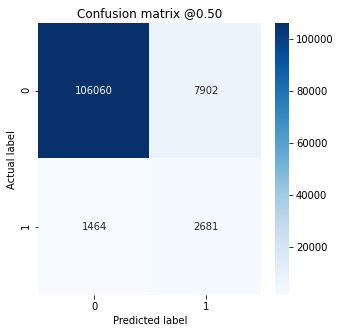

In [25]:
mf.plot_cm(y_test, y_pred, 'Blues')

AUC:  0.8873659217538261


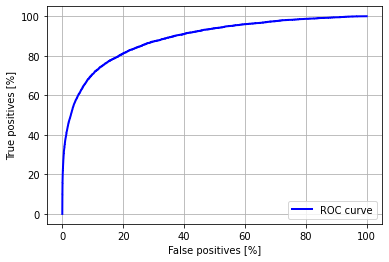

In [26]:
mf.plot_roc("ROC curve", y_test, y_pred,color='blue')

Average precision:  0.4597635102349572


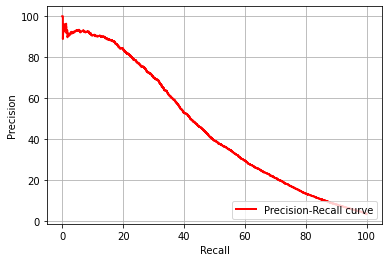

In [27]:
mf.plot_ap('Precision-Recall curve', y_test, y_pred, color = 'red')

In [28]:
y_predicted = []
for prob in y_pred:
  if prob >= 0.5:
    y_predicted.append(1)
  else:
    y_predicted.append(0)

In [29]:
from sklearn.metrics import f1_score, recall_score, precision_score
print('F1 score: ',f1_score(y_test, y_predicted, average="binary"))
print('Recall: ', recall_score(y_test, y_predicted, average='binary'))
print('Precision: ', precision_score(y_test, y_predicted,  average='binary'))

F1 score:  0.36406844106463876
Recall:  0.6468033775633293
Precision:  0.2533308135689313
